# **Open Circuit Potential (OCP) Balancing**

This notebook is created to provide an example of using PyBaMM-param package when balancing OCP curve with shifting and stretching the fitted curve to experimental data. This can also be found in `scripts/ocp_balance.py` as Python function.

In [1]:
import os
import pbparam
import pandas as pd
# os.chdir(pbparam.__path__[0] + "/../..")
os.chdir("../..")

We have 4 different files in this example. 2 for half-cell and 2 for three-electrode full cell. They are divided for their lithiation and delithiation stage.

In [2]:
#  .csv files are uploaded
anode_half_lit = pd.read_csv(os.path.join("data", "anode_OCP_2_lit.csv"))
anode_half_delit = pd.read_csv(os.path.join("data", "anode_OCP_2_delit.csv"))
anode_three_lit = pd.read_csv(os.path.join("data", "anode_OCP_3_lit.csv"))
anode_three_delit = pd.read_csv(os.path.join("data", "anode_OCP_3_delit.csv"))

Then, optimisation problem should be passed to pbparam with the data to be used as below.

In [3]:
ocp_balance = pbparam.OCPBalance(
    [anode_three_lit, anode_three_delit], [anode_half_lit, anode_half_delit]
)


Optimiser to minimise cost function should be selected in the nest step as below.

In [4]:
optimiser = pbparam.ScipyMinimize(
    method="Nelder-Mead", solver_options={"xatol": 1e-12, "fatol": 1e-12}
)

```optimiser.optimise(optimisation_problem)``` should be used to run minimasiation algorithm.

In [5]:
result = optimiser.optimise(ocp_balance)

C:\Users\Sogut2_M\AppData\Roaming\Python\Python38\site-packages\pbparam\optimisers\scipy_minimize.py:33: OptimizeWarning: Initial guess is not within the specified bounds
  raw_result = minimize(


shif and stretch values and final cost function value can be printed as below.

In [6]:
print(result.x, result.fun)

[3.22625625e-08 2.08435249e-01] 0.44240466307027293


PyBaMM-param has built in plot function to represent results.

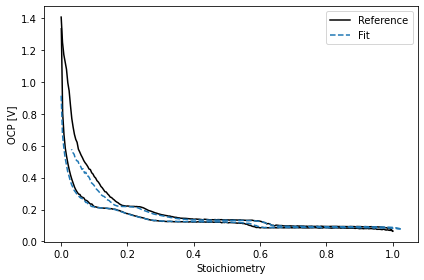

In [7]:
result.plot();